# DKRZ example

## E-OBS daily data: &nbsp; &nbsp; wet days

2024 copyright DKRZ licensed under CC BY-NC-SA 4.0 (https://creativecommons.org/licenses/by-nc-sa/4.0/deed.en)

----

<br>

### Description

This notebook demonstrates the data processing using python-cdo

- extract the rainfall data greater than 1mm (wet days) for the year 2023
- compute the climatology of the wet days for 1991-2020
- compute the anomalies in the number of wet days for 2023
- add up the number of wet days to monthly values

In this example, we use the **rr** variable of the **E-OBS** dataset. 
The data extraction and computations in this notebook are done primarily using the **python-CDO** package.

### Data description

The data grid resolution used in this notebook is 0.25° x 0.25°.

From the E-OBS data documentation at CDS:

    The E-OBS daily gridded meteorological data for Europe from 1950 to present derived 
    from in-situ observations.
    Gridtype:    regular latlon
    Resolution:  0.1° x 0.1° and 0.25° x 0.25°
    Variables:   Precipitation amount in mm

    We acknowledge the E-OBS dataset and the data providers in the ECA&D project 
    ( https://www.ecad.eu).
    Cornes, R., G. van der Schrier, E.J.M. van den Besselaar, and P.D. Jones. 2018: 
    An Ensemble Version of the E-OBS Temperature and Precipitation Datasets, J. Geophys. Res. Atmos., 
    123. doi:10.1029/2017JD028200"

    Download: https://cds.climate.copernicus.eu/cdsapp#!/dataset/10.24381/cds.151d3ec6?tab=overview
    Copernicus Climate Change Service, Climate Data Store, (2020): 
    E-OBS daily gridded meteorological data for Europe from 1950 to present derived from in-situ 
    observations. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). 
    DOI: 10.24381/cds.151d3ec6 (Accessed on DD-MMM-YYYY)

----

### python-CDO:

For the computations in this notebook we use the python-CDO package, the Python bindings of CDO (Climate Data Operators). 

    Schulzweida, Uwe. (2023). CDO User Guide (2.3.0). Zenodo. https://doi.org/10.5281/zenodo.10020800

----

### Inspired by

This example was inspired Copernicus _'Europe in 2023, Precipitation'_ by https://climate.copernicus.eu/esotc/2023/precipitation 

- Figure 3b: _'Anomalies in the number of wet days in 2023'_

----

### Notes:

- The cartopy map projection Transverse Mercator with a given central_longitude=10. leads to a strange behavior of the cartopy.features. Use `ccrs.TransverseMercator(central_longitude=11.,central_latitude=50.) ` instead.

<br>

----


In [1]:
import os
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.colorbar as colorbar

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cdo import Cdo
cdo = Cdo()

### Function: add_copyright(ax)
Add the copyright und data information text to the figure.

In [2]:
def add_copyright(x=0.7, y=0.1, dy=0.011, fs=6):
    '''Add the copyright and data information to the figure.
    '''
    fig.text(x, y,       '© 2024 CC BY-NC-SA 4.0 4.0: DKRZ', fontsize=fs)
    fig.text(x, y-dy, 'Data: E-OBS doi:10.1029/2017JD028200', fontsize=fs)
    fig.text(x, y-dy*2, 'Inspired by Copernicus: Europe in 2023', fontsize=fs)

### Function: add_colorbar()

Add a colorbar to the plot.

In [3]:
def add_colorbar(plot, bounds=None, cbar_labels=None, label=None, shrink=0.7, pad=0.06):
    '''Add a colorbar to the plot.
    '''
    extend = 'both'
    
    cbar = plt.colorbar(plot, shrink=shrink, pad=pad, extend=extend)

    if label is not None: cbar.set_label(label, rotation=270, labelpad=15)
    if bounds is not None: cbar.set_ticks(bounds)
    if cbar_labels is not None: cbar.set_ticklabels(cbar_labels)
    
    cbar.solids.set_edgecolor('white')
    cbar.solids.set_linewidth(1)
    cbar.outline.set_edgecolor('white')
    cbar.outline.set_linewidth(1)
    cbar.ax.tick_params(which='minor', length = 0)
    cbar.ax.tick_params(which='major', length = 0)

### Colormap

For precipitation data we use a colormap with colors from **brown to blue** <u>without</u> white in the middle. 

In [4]:
color_list = [[0.418, 0.266, 0.137, 1.], [0.957, 0.957, 0.859, 1.], 
              [0.9375, 0.969, 1., 1.],   [0.0, 0.137, 0.527, 1.]]
nodes = [0.0, 0.5, 0.5, 1.0]

cmap = mcolors.LinearSegmentedColormap.from_list('brown2blue', list(zip(nodes, color_list)))
#cmap

### Merge files

In our case the precipitation data of the reference and year 2023 data are stored in 3 file which have to be merged.

In [5]:
dpath = os.environ['HOME']+'/data/E-OBS/'

prfiles = dpath+'rr_ens_mean_0.25deg_reg_*_v29.0e.nc'

pr_all = dpath+'pr_merged.nc'

In [6]:
#-- if file does not exist the merge of the data files will take some time
if not os.path.exists(pr_all): 
    print('--- pr_all: merged data does not exist')
    print('---         merge data ...')
    _ = cdo.mergetime(input=f'{prfiles}', output=pr_all)

### Longitude and latitude coordinates

Open dataset and read the longitudes and latitudes.

In [7]:
ds_all = xr.open_dataset(pr_all)

lon = ds_all.longitude
lat = ds_all.latitude

### Map projection and data transformation

Choose a map projection and tell Cartopy which coordinate system is used for the data with the transform argument.

In [8]:
projection = ccrs.TransverseMercator(central_longitude=11.,
                                    central_latitude=50.)
transform = ccrs.PlateCarree()

### Data bounds

In [9]:
bounds = np.linspace(-50, 50, 11)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

cbar_labels = [f'{int(x):3d}' for x in bounds]

### Climatology yearly sum

Climatology data greater than 1mm rainfall, count the days for each grid cell, and compute the mean along time axis.

In [10]:
var_cw = cdo.timmean(input=f'-yearsum -gtc,1 -selyear,1991/2020 {pr_all}', 
                     options='--reduce_dim', returnXArray='rr')

var_cw.attrs['long_name'] = 'number of wet days'
var_cw.attrs['units'] = ''

In [11]:
print(var_cw.min().values, var_cw.max().values)
print(var_cw.shape)

0.0 243.6
(201, 464)


### Data 2023 yearly sum

Daily data values greater than 1mm rainfall, count the days for each grid cell.

In [12]:
var_2023w = cdo.yearsum(input=f'-gtc,1 -selyear,2023 {pr_all}', 
                        options='--reduce_dim', returnXArray='rr')

var_2023w.attrs['long_name'] = 'number of wet days'
var_2023w.attrs['units'] = ''

In [13]:
print(f'min: {var_2023w.min().values:.2f},  mean: {var_2023w.mean().values:.2f}, max: {var_2023w.max().values:.2f}')

min: 0.00,  mean: 118.76, max: 253.00


### Anomaly 2023 of yearly sums

Compute the wet days anomaly be subtracting the wet days climatology from the wet days data in 2023.

In [14]:
var_wetdays = (var_2023w - var_cw).squeeze()

var_wetdays.attrs['long_name'] = 'number of wet days'
var_wetdays.attrs['units'] = ''

### Plot the anomalies in the number of wet days in 2023

Generate a perfect plot of the European wet days anomalies for the year 2023.

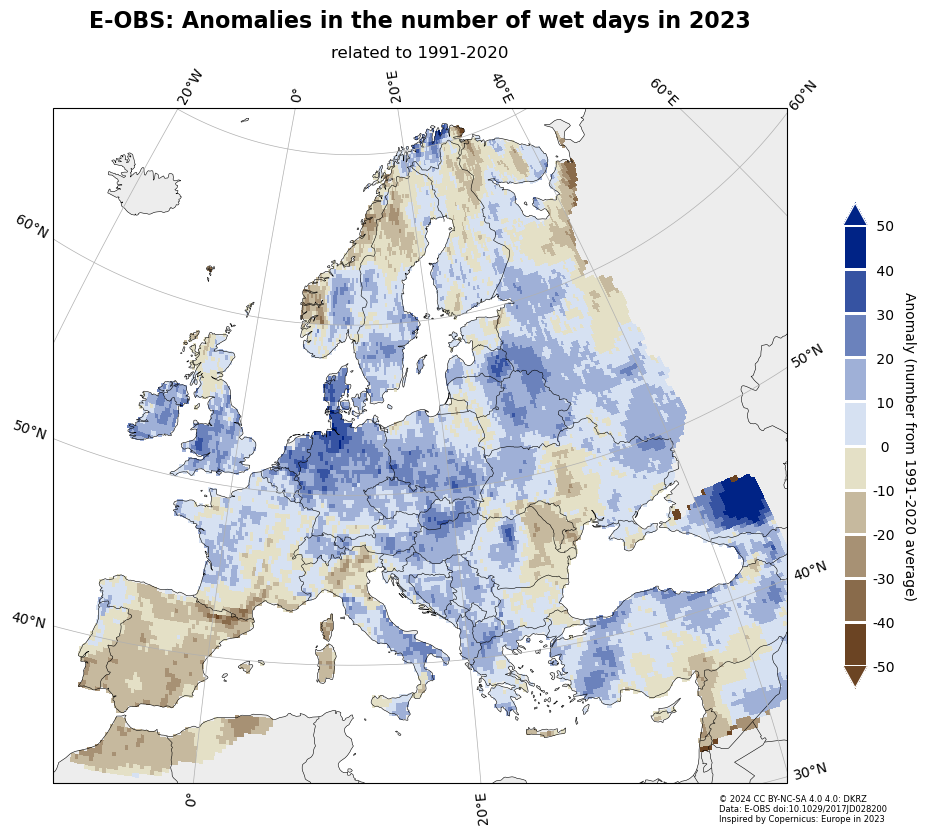

In [15]:
fig, ax = plt.subplots(figsize=(12,9), 
                       subplot_kw=dict(projection=projection))

#-- zoom in map, draw coastlines, fill ocean and land, draw gridlines
ax.set_extent([lon.min()+31., lon.max()-35., lat.min()+6., lat.max()-5])
ax.coastlines(resolution='50m', lw=0.4)
ax.gridlines(draw_labels=True, lw=0.5)
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='white')
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='gainsboro', alpha=0.5)
ax.add_feature(cfeature.BORDERS, lw=0.4);

#-- generate the raster plot
plot = ax.pcolormesh(lon, lat, var_wetdays, 
                     #vmin=-50., 
                     #vmax=50., 
                     cmap=cmap, 
                     norm=norm,
                     transform=transform)

#-- add colorbar
add_colorbar(plot, bounds=bounds, cbar_labels=cbar_labels, 
             label='Anomaly (number from 1991-2020 average)', 
             shrink=0.7, pad=0.06)

#-- add and center title and suptitle strings above axis
ax_bbox = ax.get_position()
middle = ax_bbox.x0 + (ax_bbox.x1 - ax_bbox.x0)/2

plt.suptitle('E-OBS: Anomalies in the number of wet days in 2023',
              fontsize=16, weight='bold', x=middle)
ax.set_title('related to 1991-2020', fontsize=12)

#-- add copyright and data information
add_copyright(x=0.68, y=0.1, dy=0.011)

#-- save figure to PNG file
fig.savefig('plot_anomalies_in_the_numer_of_wet_days_in_2023', 
             bbox_inches='tight', facecolor='white', dpi=150);

----

### Wet days monthly

#### Climatology number of wet days monthly mean


In [16]:
var_cwm = cdo.ymonmean(input=f'-monsum -gtc,1 -selyear,1991/2020 {pr_all}', 
                       options='--reduce_dim', returnXArray='rr')

var_cwm.attrs['long_name'] = 'number of wet days'
var_cwm.attrs['units'] = ''

In [17]:
print(var_cwm.min().values, var_cwm.max().values)
print(var_cwm.shape)

0.0 23.9
(12, 201, 464)


#### Data 2023 number of wet days monthly

In [18]:
var_wdm = cdo.ymonsum(input=f'-gtc,1 -selyear,2023 {pr_all}', 
                      options='--reduce_dim', returnXArray='rr')

var_wdm.attrs['long_name'] = 'number of wet days'
var_wdm.attrs['units'] = ''

In [19]:
print(var_wdm.min().values, var_wdm.max().values)
print(var_wdm.shape)

0.0 30.0
(12, 201, 464)


#### Anomaly 2023 number of wet days monthly

In [20]:
var_wet_anom_mon = xr.apply_ufunc(
    lambda x, mean: x - mean,
    var_wdm.groupby('time.month'),
    var_cwm.groupby('time.month').mean()
).drop('month')

This calculation is the same as the following done with CDO.

```python
cdo.ymonmean(input=f'-monsum -gtc,1 -selyear,1991/2020 {pr_all}', options='--reduce_dim', output='tmp_clim.nc')
cdo.monsum(input=f'-gtc,1 -selyear,2023 {pr_all}', options='--reduce_dim', output='tmp_2023ms.nc')
cdo.sub(input='tmp_2023ms.nc tmp_clim.nc', output='tmp_2023anom_ms.nc')
```

In [21]:
print(var_wet_anom_mon.min().values, var_wet_anom_mon.max().values)
print(var_wet_anom_mon.shape)

-14.300001 16.4
(12, 201, 464)


Set the value bounds for the colors.

In [22]:
bounds = np.arange(-15, 20, 5)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

cbar_labels = [f'{int(x):3d}' for x in bounds]
cbar_title = 'Anomaly number of wet days'

#### Plot anomalies 2023 number of wet days monthly

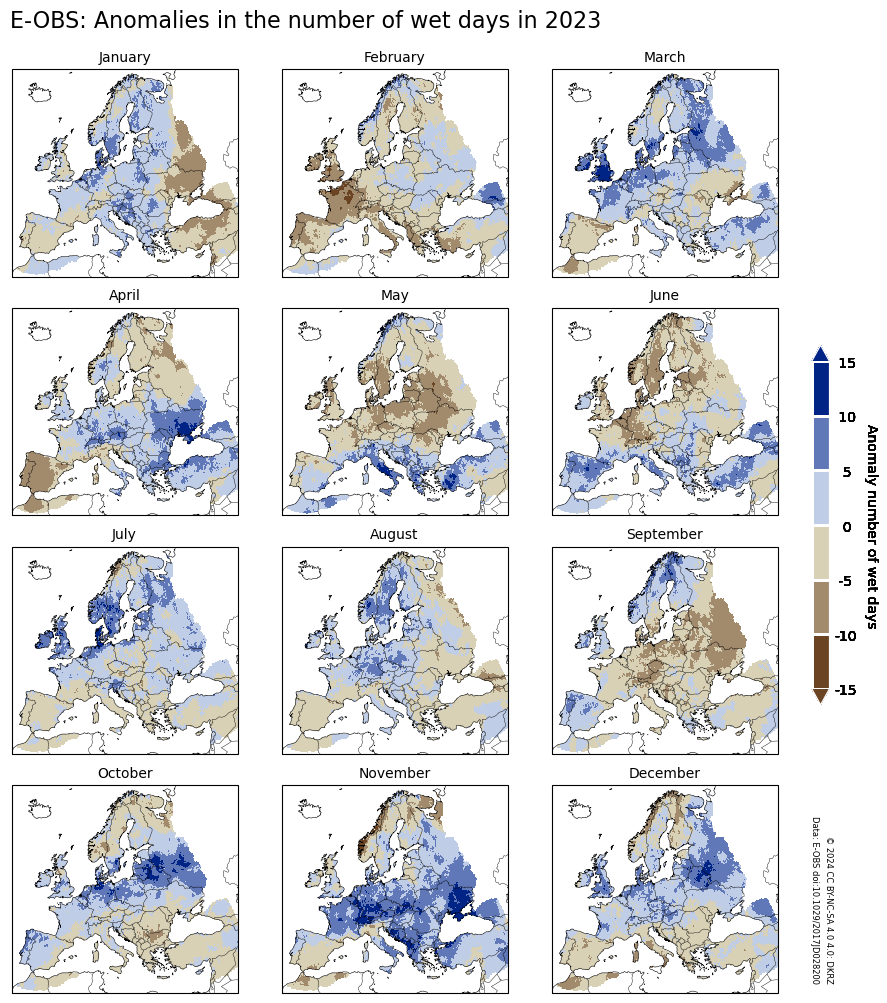

In [23]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12,12),
                         subplot_kw=dict(projection=projection))

fig.suptitle('E-OBS: Anomalies in the number of wet days in 2023', 
             x=0.142, y=0.93, ha='left', fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.set_extent([lon.min()+31., lon.max()-35., lat.min()+6., lat.max()-5])
    ax.coastlines(resolution='50m', lw=0.4)
    ax.add_feature(cfeature.BORDERS, lw=0.3)
    
    ax.set_title(f'{var_wet_anom_mon.time[i].dt.strftime("%B").values}', fontsize=10)
    
    plot = ax.pcolormesh(lon, lat, var_wet_anom_mon.isel(time=i), 
                         cmap=cmap, 
                         norm=norm,
                         transform=transform)
    
    plt.subplots_adjust(wspace=0.0, hspace=0.15)
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.81, 0.35, 0.015, 0.3])
    cbar = fig.colorbar(plot, cax=cbar_ax, cmap=cmap, norm=plt.Normalize(-15,15), 
                        extend='both')

    cbar.set_label(cbar_title, rotation=270, labelpad=15, weight='normal')
    cbar.set_ticks(bounds)
    cbar.set_ticklabels(cbar_labels, weight='normal')
    cbar.solids.set_edgecolor('white')
    cbar.solids.set_linewidth(1)
    cbar.outline.set_edgecolor('white')
    cbar.outline.set_linewidth(1)
    cbar.ax.tick_params(which='minor', length = 0)
    cbar.ax.tick_params(which='major', length = 0)

dx = 0.011
x, y = 0.82, 0.12
fig.text(x,      y, '© 2024 CC BY-NC-SA 4.0 4.0: DKRZ', rotation=270, fontsize=6)
fig.text(x-dx,   y, 'Data: E-OBS doi:10.1029/2017JD028200', rotation=270, fontsize=6)

fig.savefig('plot_anomalies_number_of_wet_days_2023_monthly.png', 
             bbox_inches='tight', facecolor='white', dpi=150);

----

#### Anomalies in monthly wet days in 2023 - percental to the climatology


Prevent zero division.

In [24]:
var_wet_anom_percent = (var_wet_anom_mon.copy(deep=True) * 0.)

for i in range(12):
    p = (var_wet_anom_mon.isel(time=i) / var_cwm.isel(time=i)) * 100. 
    p = p.where(p != np.inf, np.nan)

    var_wet_anom_percent.loc[var_wet_anom_mon.time.dt.month == i+1] = p
    print(f'{var_wet_anom_percent.isel(time=i).min().values} to {var_wet_anom_percent.isel(time=i).max().values}')

-100.0 to 218.18182373046875
-100.0 to 215.78945922851562
-100.0 to 167.60562133789062
-100.0 to 233.3333282470703
-100.0 to 455.5555419921875
-100.0 to 1150.0
-100.0 to 900.0
-100.0 to 1900.0
-100.0 to 900.0
-100.0 to 321.0526123046875
-100.0 to 400.0
-100.0 to 150.0


Adapt bounds and colorbar labels.

In [25]:
bounds = np.arange(-150, 175, 25)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

cbar_labels = [f'{int(x):3d}' for x in bounds]
cbar_title = 'Anomaly (% of 1991-2020 number of wet days)'

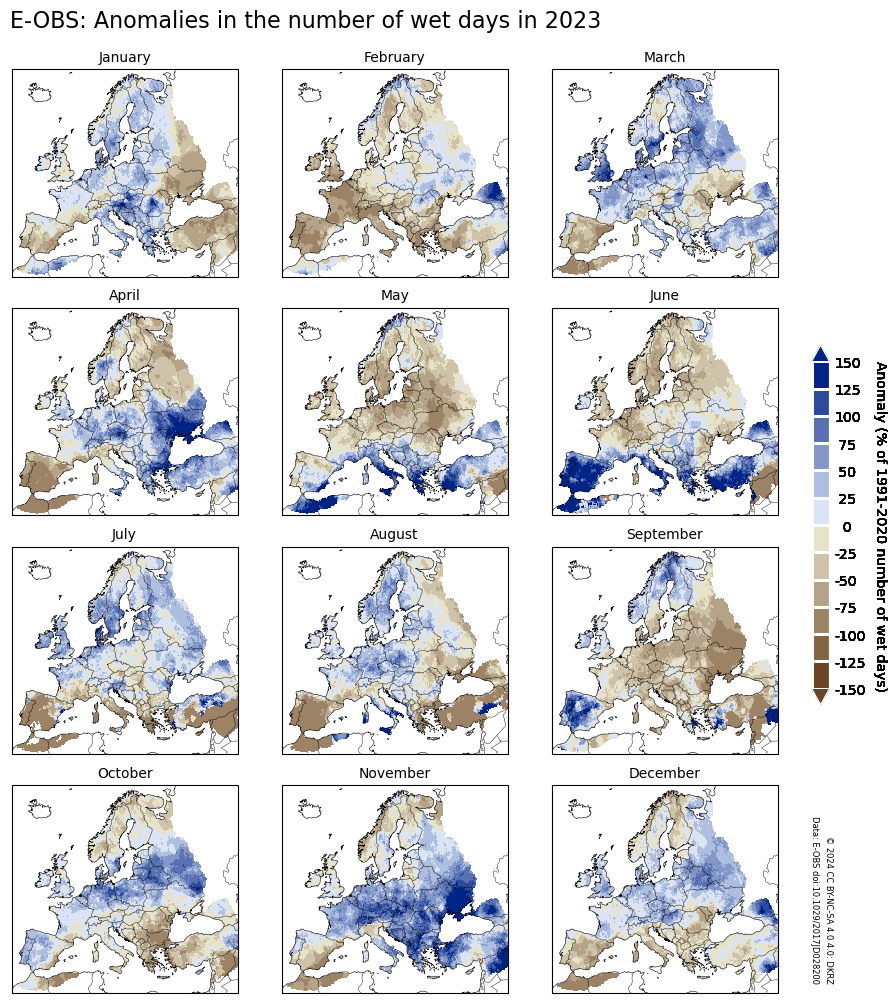

In [26]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12,12),
                         subplot_kw=dict(projection=projection))

fig.suptitle('E-OBS: Anomalies in the number of wet days in 2023', 
             x=0.142, y=0.93, ha='left', fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.set_extent([lon.min()+31., lon.max()-35., lat.min()+6., lat.max()-5])
    ax.coastlines(resolution='50m', lw=0.4)
    ax.add_feature(cfeature.BORDERS, lw=0.3)
    
    ax.set_title(f'{var_wet_anom_mon.time[i].dt.strftime("%B").values}', fontsize=10)
    
    plot = ax.pcolormesh(lon, lat, 
                         var_wet_anom_percent.isel(time=i), 
                         cmap=cmap, 
                         norm=norm,
                         transform=transform)
    
    plt.subplots_adjust(wspace=0.0, hspace=0.15)
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.81, 0.35, 0.015, 0.3])
    cbar = fig.colorbar(plot, cax=cbar_ax, cmap=cmap, norm=plt.Normalize(-15,15), 
                        extend='both')
    cbar.set_label(cbar_title, rotation=270, labelpad=15, weight='normal')
    cbar.set_ticks(bounds)
    cbar.set_ticklabels(cbar_labels, weight='normal')
    cbar.solids.set_edgecolor('white')
    cbar.solids.set_linewidth(1)
    cbar.outline.set_edgecolor('white')
    cbar.outline.set_linewidth(1)
    cbar.ax.tick_params(which='minor', length = 0)
    cbar.ax.tick_params(which='major', length = 0)

dx = 0.011
x, y = 0.82, 0.12
fig.text(x,      y, '© 2024 CC BY-NC-SA 4.0 4.0: DKRZ', rotation=270, fontsize=6)
fig.text(x-dx,   y, 'Data: E-OBS doi:10.1029/2017JD028200', rotation=270, fontsize=6)

fig.savefig('plot_anomalies_number_of_wet_days_percental_to_clim_2023_monthly.png', 
             bbox_inches='tight', facecolor='white', dpi=150);